In [1]:
# Exploring Distributed Functional Representations with fMRI: A Modern Take on Haxby et al. (2001)

"""
This notebook revisits the Haxby et al. (2001) study using modern MVPA techniques to analyze distributed representations in the brain. 
We will visualize fMRI data, apply masking techniques, and analyze event-related activity using two ML models.
"""

# Import necessary libraries
import numpy as np  # Numerical computations
import pandas as pd  # Data handling and manipulation
import matplotlib.pyplot as plt  # Plotting and visualization
import seaborn as sns  # Enhanced visualizations
from nilearn import datasets, plotting, image  # Neuroimaging-specific functions
from nilearn.masking import apply_mask, unmask  # Masking utilities
from scipy.stats import zscore #zscore function
from scipy.ndimage import distance_transform_edt  # Distance calculations for spherical masks
from nilearn.input_data import NiftiMasker  # For applying mask and standardizing data

# Suppress all warnings - normally we dont do this, but wanna make things a bit cleaner
import warnings
warnings.filterwarnings('ignore')

# Load the Haxby dataset (fMRI data of a subject viewing different categories of images)
haxby_dataset = datasets.fetch_haxby(subjects=[2], fetch_stimuli=True)

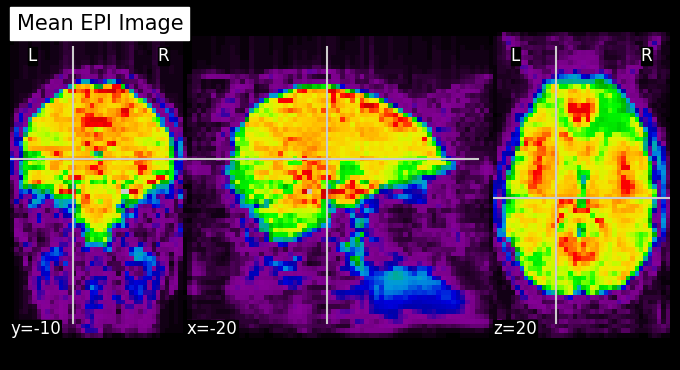


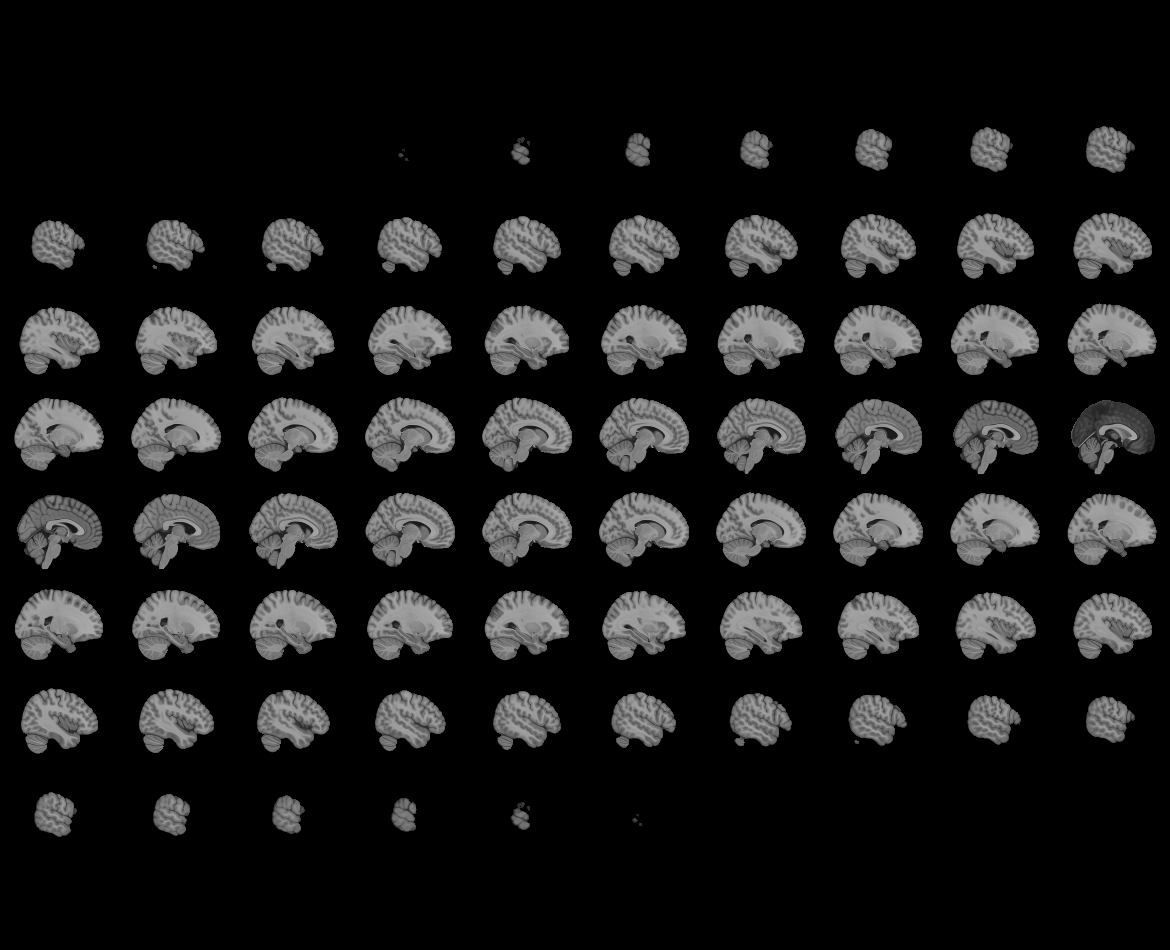
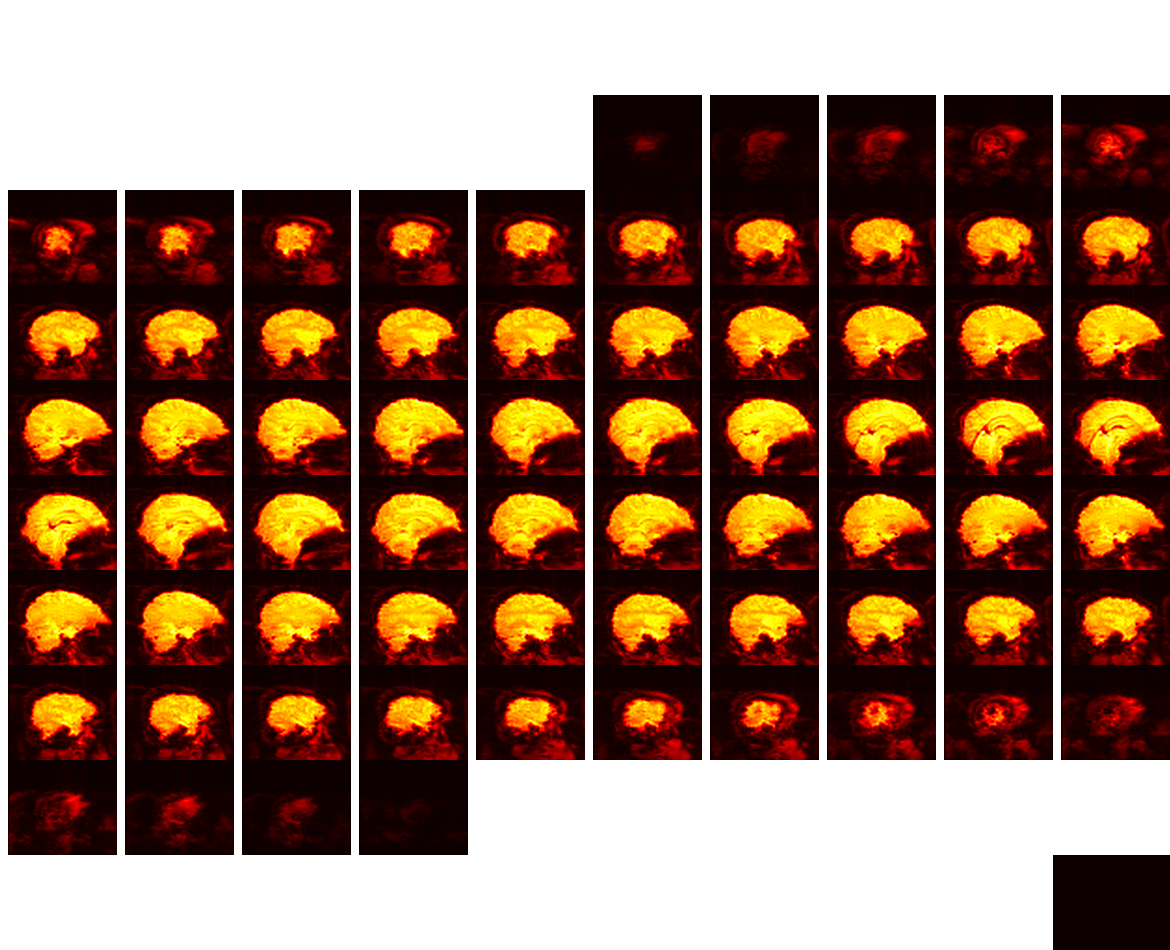

In [2]:
"""
The mean EPI image provides an average representation of brain activity over time. 
In this image, we can see the structural boundaries of the brain as well as areas where the BOLD signal is most prominent. 
The coordinates chosen here (-20, -10, 20) correspond to slices that provide clear views of key brain areas. 
Adjusting these coordinates can help in visualizing different brain regions.
"""

# Load the fMRI data for visualization
fmri_filename = haxby_dataset.func[0]

# Generate a mean image from the fMRI data
mean_img_ = image.mean_img(fmri_filename)

# Visualize the mean EPI (Echo-Planar Imaging) data at a specified coordinate
plotting.plot_epi(mean_img_, cut_coords=[-20, -10, 20], title="Mean EPI Image")
plt.show()

#3D view of the mean EPI image
plotting.view_img(mean_img_, title="Interactive 3D View")

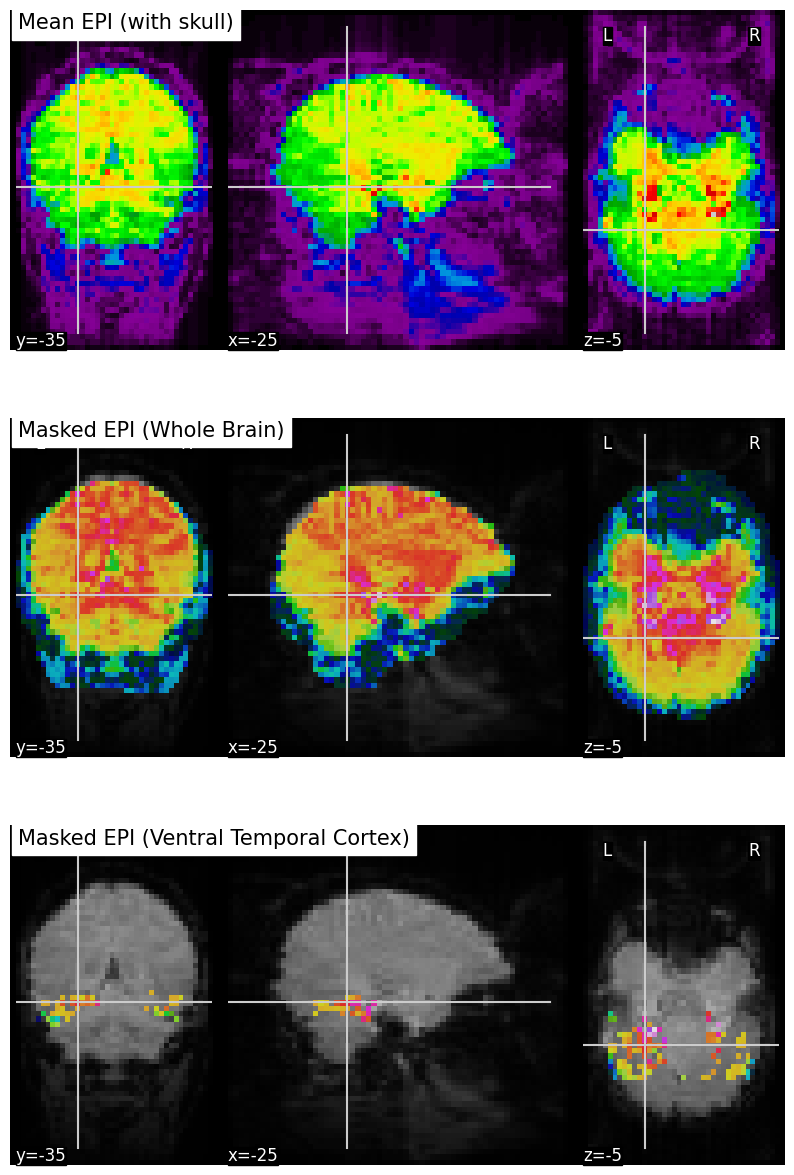

In [3]:
"""
In this section, we apply different masks to focus on specific brain regions. 
The ventral temporal (VT) mask, in particular, is crucial for analyzing the ventral visual stream, which includes areas like the fusiform face area (FFA) and parahippocampal place area (PPA). 
These regions are known for processing faces and places, respectively. 
By comparing the whole-brain mask with the VT mask, we can see how masking helps isolate activity in these regions, reducing noise from irrelevant areas.
"""

# Load the ventral temporal (VT) and whole-brain masks
mask_vt_filename = haxby_dataset.mask_vt[0]
mask_filename = haxby_dataset.mask

# Apply masks to the fMRI data
masked_fmri_vt = apply_mask(fmri_filename, mask_vt_filename)
masked_fmri = apply_mask(fmri_filename, mask_filename)

# Unmask the data to visualize it
unmasked_fmri_vt = unmask(masked_fmri_vt, mask_vt_filename)
unmasked_fmri = unmask(masked_fmri, mask_filename)

# Create subplots for visual comparison
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Plotting the mean EPI image with skull
plotting.plot_epi(mean_img_, title="Mean EPI (with skull)", axes=axes[0], cut_coords=[-25, -35, -5], colorbar=False)

# Plotting the whole-brain masked EPI image
plotting.plot_roi(image.mean_img(unmasked_fmri), bg_img=mean_img_, title="Masked EPI (Whole Brain)", axes=axes[1], cut_coords=[-25, -35, -5], colorbar=False)

# Plotting the VT mask
plotting.plot_roi(image.mean_img(unmasked_fmri_vt), bg_img=mean_img_, title="Masked EPI (Ventral Temporal Cortex)", axes=axes[2], cut_coords=[-25, -35, -5], colorbar=False)

plt.show()

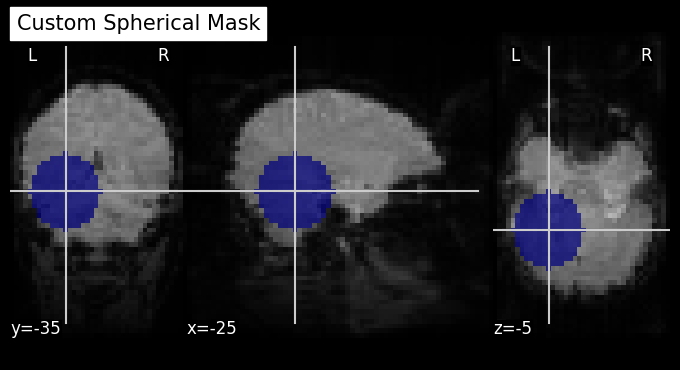

In [4]:
"""
Spherical masks allow us to focus on specific regions within the brain. 
For example, we might use a spherical mask to analyze activity around the hippocampus, a region involved in memory processing. 
By adjusting the MNI coordinates and radius, we can target different brain areas, making spherical masks a versatile tool in fMRI analysis.
"""


# Function to create a spherical mask at specified coordinates
def create_sphere_mask(mni_coord, sphere_radius, mean_img_):
    """
    This function creates a spherical mask centered at a specific MNI coordinate.
    Spherical masks are useful for focusing on localized regions in the brain, particularly in searchlight analyses.
    """
    # Convert MNI coordinates to voxel space
    voxel_coord = np.round(image.coord_transform(*mni_coord, np.linalg.inv(mean_img_.affine))).astype(int)

    # Create a blank image with the same shape as the mean image
    mask_sphere_data = np.zeros(mean_img_.shape, dtype=bool)

    # Set the voxel at the coordinate to True
    mask_sphere_data[tuple(voxel_coord)] = True

    # Compute the Euclidean distance transform
    distance_map = distance_transform_edt(~mask_sphere_data)

    # Threshold the distance map to create the sphere mask
    sphere_mask = distance_map <= sphere_radius

    # Convert the mask data to a Nifti image
    mask_sphere_img = image.new_img_like(mean_img_, sphere_mask.astype(np.int32))

    return mask_sphere_img

# Example coordinates and radius for creating a spherical mask
mni_coord = [-25, -35, -5]  # Coordinates in MNI space
sphere_radius = 8  # Radius in voxels

# Generate and plot the spherical mask
mask_sphere_img = create_sphere_mask(mni_coord, sphere_radius, mean_img_)
plotting.plot_roi(mask_sphere_img, bg_img=mean_img_, title="Custom Spherical Mask", cut_coords=mni_coord, colorbar=False)
plt.show()

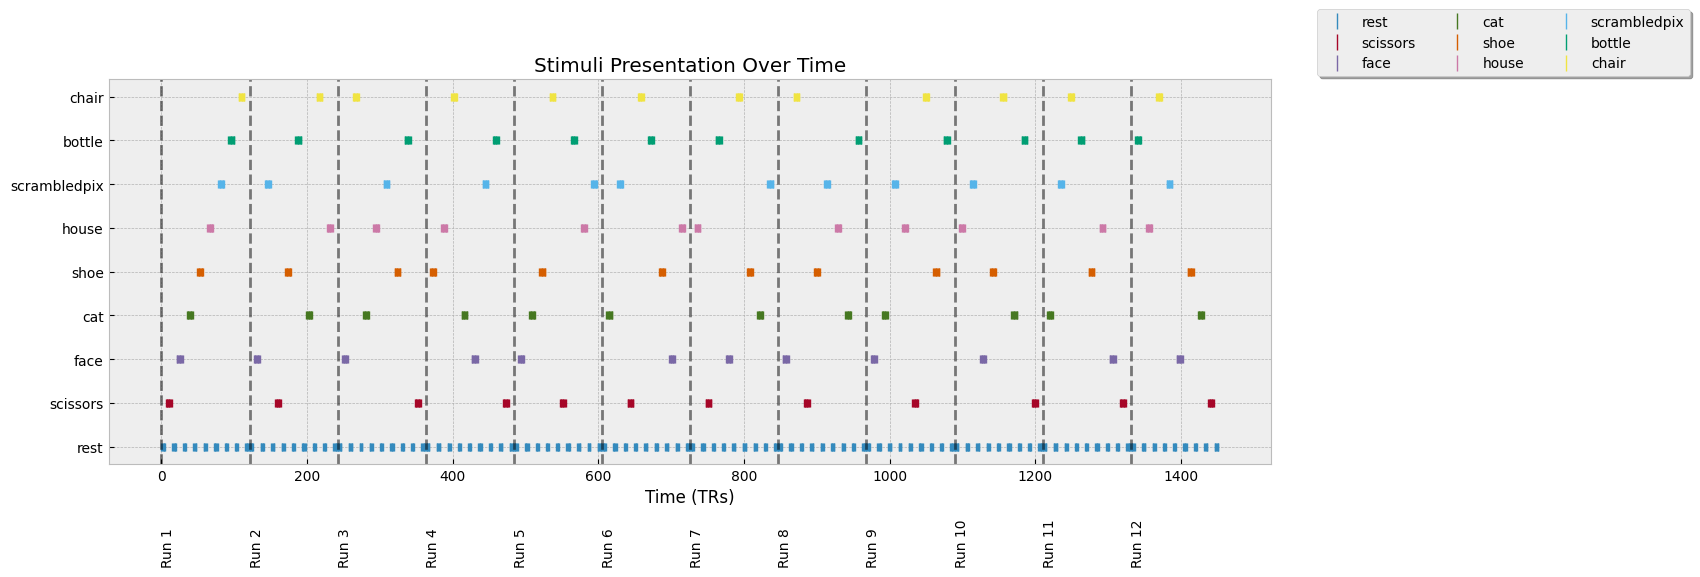

Average time between stimuli presentations:
labels
bottle          11.710280
cat             13.046729
chair           11.850467
face            12.906542
house           12.121495
rest             2.471891
scissors        13.448598
scrambledpix    12.242991
shoe            12.785047
dtype: float64


In [5]:
"""
Understanding when different stimuli were presented during the experiment is crucial for interpreting the corresponding brain activity. 
This visualization helps align the BOLD signal with specific experimental conditions, providing insights into how the brain processes different categories of visual stimuli. 
The vertical lines distinguish different runs, which are important for separating distinct blocks of the experiment and ensuring that analyses account for session-specific variability.
"""

# Load the behavioral data
behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = behavioral["labels"].values
sessions = behavioral["chunks"].values

# Visualize the timing of different stimuli
plt.style.use("bmh")
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the conditions over time
for i, condition in enumerate(behavioral["labels"].unique()):
    condition_times = behavioral[behavioral["labels"] == condition].index
    ax.plot(condition_times, [i] * len(condition_times), "|", label=condition)

# Add vertical lines and labels to distinguish runs
run_starts = behavioral[behavioral["chunks"].diff() != 0].index
for i, run_start in enumerate(run_starts):
    ax.axvline(x=run_start, color="k", alpha=0.5, linestyle="--")
    ax.text(run_start, -2.75, f"Run {i+1}", rotation=90, verticalalignment="bottom")

ax.set_title("Stimuli Presentation Over Time")
ax.set_xlabel("Time (TRs)")
ax.set_yticks(range(len(behavioral["labels"].unique())))
ax.set_yticklabels(behavioral["labels"].unique())
ax.legend(loc="upper center", bbox_to_anchor=(1.2, 1.2), ncol=3, fancybox=True, shadow=True, markerscale=2)
plt.show()

print("=================================================================")
# Expand analysis: Calculate the timing between stimuli presentations
time_diffs = behavioral.groupby('labels').apply(lambda x: x.index.to_series().diff().mean())
print(f"Average time between stimuli presentations:\n{time_diffs}")

In [6]:
# Z-score the BOLD data within each run separately

# Create a NiftiMasker object for applying the mask (without standardization)
masker = NiftiMasker(mask_img=mask_filename)

# Apply the masker to the fMRI data (this applies the whole-brain mask)
fmri_masked = masker.fit_transform(fmri_filename)

# Get the session labels (runs) from the behavioral data
session_labels = behavioral["chunks"].values

# Initialize an array to store the z-scored data
fmri_masked_zscored = np.zeros_like(fmri_masked)

# Perform z-scoring within each run
for run in np.unique(session_labels):
    run_indices = np.where(session_labels == run)[0]
    fmri_masked_zscored[run_indices] = zscore(fmri_masked[run_indices], axis=0)

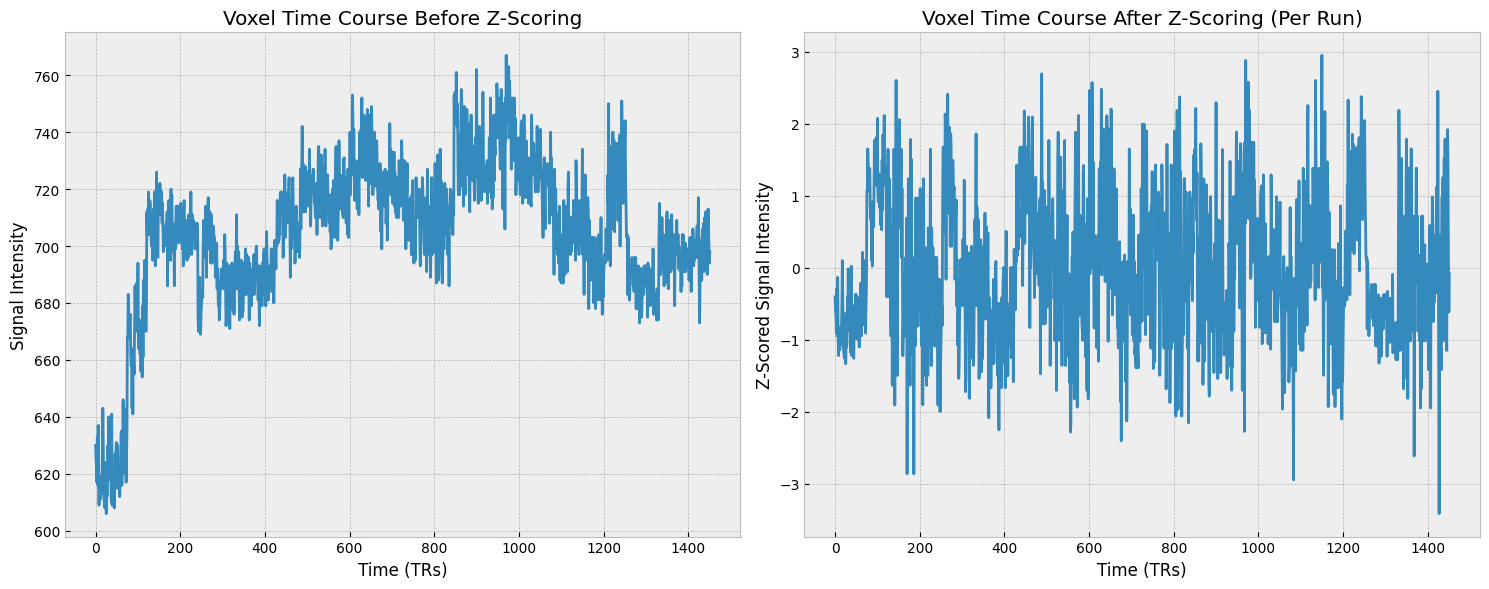

Shape of the z-scored BOLD data (Per Run): (1452, 39912)


In [7]:
# Extract the time course for a random voxel before z-scoring
voxel_time_course_before = fmri_masked[:, 1000]

# Extract the time course for this voxel after z-scoring
voxel_time_course_after = fmri_masked_zscored[:, 1000]

# Plot the time course before and after z-scoring
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(voxel_time_course_before)
plt.title("Voxel Time Course Before Z-Scoring")
plt.xlabel("Time (TRs)")
plt.ylabel("Signal Intensity")

plt.subplot(1, 2, 2)
plt.plot(voxel_time_course_after)
plt.title("Voxel Time Course After Z-Scoring (Per Run)")
plt.xlabel("Time (TRs)")
plt.ylabel("Z-Scored Signal Intensity")

plt.tight_layout()
plt.show()

# Check the shape of the z-scored data to confirm it's processed correctly
print(f"Shape of the z-scored BOLD data (Per Run): {fmri_masked_zscored.shape}")

In [8]:
# Apply the VT mask to extract the relevant voxel data
masked_fmri_vt = apply_mask(fmri_filename, mask_vt_filename)

# Check the shape of the extracted data
print("Shape of masked fMRI data (VT region):", masked_fmri_vt.shape)

# This shape should be (n_timepoints, n_voxels), where n_voxels is the number of voxels within the VT mask

Shape of masked fMRI data (VT region): (1452, 464)


In [9]:
# Apply the VT mask to the z-scored fMRI data

# Initialize the masker for the VT region
vt_masker = NiftiMasker(mask_img=mask_vt_filename)

# Apply the VT mask to the z-scored fMRI data
fmri_vt_masked_zscored = vt_masker.fit_transform(masker.inverse_transform(fmri_masked_zscored))

# Check the shape of the VT masked z-scored data
print(f"Shape of the VT masked z-scored BOLD data: {fmri_vt_masked_zscored.shape}")

Shape of the VT masked z-scored BOLD data: (1452, 464)


In [10]:
# Define the HRF delay in TRs
HRF_TR_shift = 2  # This is typically around 4-6 seconds, so 2 TRs (TR = 2.5s)

# Shift the labels to account for the HRF delay
shifted_conditions = np.roll(conditions, -HRF_TR_shift)

# Filter out the last few time points that are shifted out of bounds
shifted_conditions = shifted_conditions[:-HRF_TR_shift]
shifted_sessions = sessions[:-HRF_TR_shift]
fmri_vt_masked_shifted = fmri_vt_masked_zscored[:-HRF_TR_shift, :]

# Remove "rest" time points from the conditions, sessions, and fMRI data
non_rest_indices = np.where(shifted_conditions != "rest")[0]

# Apply the filter to keep only non-rest data
filtered_conditions = shifted_conditions[non_rest_indices]
filtered_sessions = shifted_sessions[non_rest_indices]
filtered_fmri_vt = fmri_vt_masked_shifted[non_rest_indices, :]

# Verify the shapes of the filtered data
print(f"Filtered conditions shape: {filtered_conditions.shape}")
print(f"Filtered fMRI data shape: {filtered_fmri_vt.shape}")
print(f"Filtered sessions shape: {filtered_sessions.shape}")

Filtered conditions shape: (864,)
Filtered fMRI data shape: (864, 464)
Filtered sessions shape: (864,)


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the logistic regression model with L2 penalty
logreg = LogisticRegression(penalty='l2', multi_class='ovr', solver='liblinear', max_iter=1000)

# Define the hyperparameter grid for tuning the regularization strength (C)
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

# Initialize the Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

# Initialize a list to store confusion matrices and AUC scores
conf_matrices = []
auc_scores = []

# Initialize an array to store true labels and predicted probabilities for AUC
y_true_all = []
y_pred_prob_all = []

print("Starting Leave-One-Run-Out Cross-Validation with Feature Selection...")

# Perform Leave-One-Run-Out cross-validation
for fold, (train_index, test_index) in enumerate(logo.split(filtered_fmri_vt, filtered_conditions, groups=filtered_sessions), 1):
    print(f"Processing fold {fold}...")

    # Split the data into training and testing sets
    X_train, X_test = filtered_fmri_vt[train_index], filtered_fmri_vt[test_index]
    y_train, y_test = filtered_conditions[train_index], filtered_conditions[test_index]

    # Set up a pipeline with feature selection and logistic regression
    pipeline = Pipeline([
        ('feature_selection', SelectKBest(f_classif, k=200)),  # Select top 200 features
        ('logisticregression', logreg)
    ])

    # Set up the grid search for hyperparameter tuning
    print("  Tuning hyperparameters...")
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_
    print(f"  Best model found with C={grid_search.best_params_['logisticregression__C']}")

    # Predict on the test set
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)

    # Store the true labels and predicted probabilities for AUC calculation
    y_true_all.extend(y_test)
    y_pred_prob_all.extend(y_pred_prob)

    # Compute and store the confusion matrix for this fold
    conf_matrices.append(confusion_matrix(y_test, y_pred, labels=grid_search.classes_))

print("Cross-validation with Feature Selection completed.")

Starting Leave-One-Run-Out Cross-Validation with Feature Selection...
Processing fold 1...
  Tuning hyperparameters...
  Best model found with C=0.1
Processing fold 2...
  Tuning hyperparameters...
  Best model found with C=0.1
Processing fold 3...
  Tuning hyperparameters...
  Best model found with C=0.01
Processing fold 4...
  Tuning hyperparameters...
  Best model found with C=0.1
Processing fold 5...
  Tuning hyperparameters...
  Best model found with C=0.1
Processing fold 6...
  Tuning hyperparameters...
  Best model found with C=0.1
Processing fold 7...
  Tuning hyperparameters...
  Best model found with C=0.1
Processing fold 8...
  Tuning hyperparameters...
  Best model found with C=0.1
Processing fold 9...
  Tuning hyperparameters...
  Best model found with C=0.1
Processing fold 10...
  Tuning hyperparameters...
  Best model found with C=0.1
Processing fold 11...
  Tuning hyperparameters...
  Best model found with C=0.01
Processing fold 12...
  Tuning hyperparameters...
  Best 

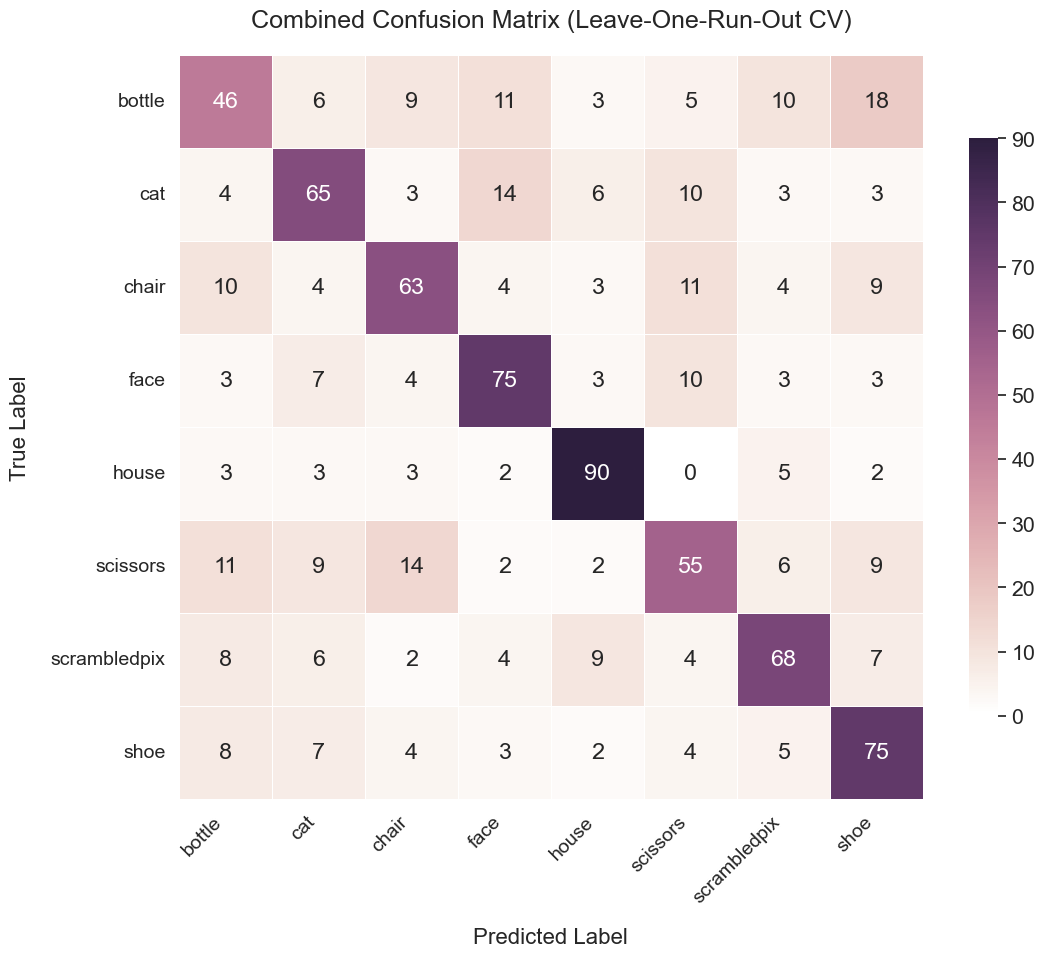

Generating ROC curves and calculating AUC scores...


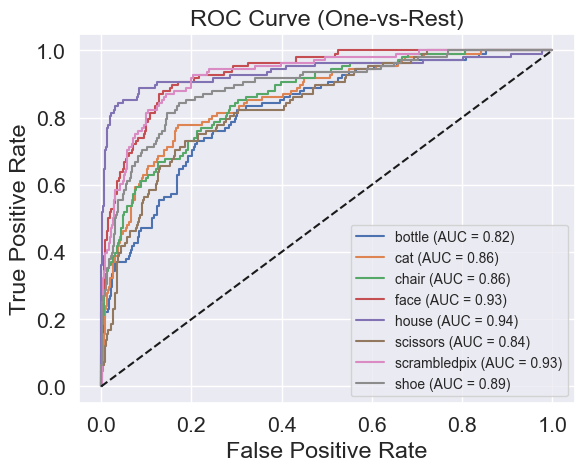

AUC scores for each class:
  bottle: AUC = 0.82
  cat: AUC = 0.86
  chair: AUC = 0.86
  face: AUC = 0.93
  house: AUC = 0.94
  scissors: AUC = 0.84
  scrambledpix: AUC = 0.93
  shoe: AUC = 0.89


In [23]:
# Combine confusion matrices across all folds
combined_conf_matrix = sum(conf_matrices)

# Plot the combined confusion matrix
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.4)  # Adjust the font scale for better readability

# Define a custom color palette
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

# Create the heatmap
sns.heatmap(
    combined_conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap=cmap, 
    xticklabels=grid_search.classes_, 
    yticklabels=grid_search.classes_,
    linewidths=.5, 
    cbar_kws={"shrink": .75},
    square=True
)

# Add titles and labels with enhanced formatting
plt.title("Combined Confusion Matrix (Leave-One-Run-Out CV)", fontsize=18, pad=20)
plt.xlabel("Predicted Label", fontsize=16, labelpad=15)
plt.ylabel("True Label", fontsize=16, labelpad=15)

# Rotate x-tick labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=14)
plt.yticks(rotation=0, fontsize=14)

plt.show()

# Convert true labels and predicted probabilities to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_prob_all = np.array(y_pred_prob_all)

# Calculate and plot the ROC curve and AUC for each class
print("Generating ROC curves and calculating AUC scores...")
for i, class_name in enumerate(grid_search.classes_):
    y_true_binary = (y_true_all == class_name).astype(int)
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_prob_all[:, i])
    auc = roc_auc_score(y_true_binary, y_pred_prob_all[:, i])
    auc_scores.append(auc)
    
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')

# Adjust legend size
plt.legend(loc='lower right', prop={'size': 10})  # Smaller legend size
plt.show()

# Print AUC scores for each class
print("AUC scores for each class:")
for class_name, auc in zip(grid_search.classes_, auc_scores):
    print(f"  {class_name}: AUC = {auc:.2f}")

In [24]:
# Set up the logistic regression model with L2 penalty
logreg_top_removed = LogisticRegression(penalty='l2', multi_class='ovr', solver='liblinear', max_iter=1000)

# Define the hyperparameter grid for tuning the regularization strength (C)
param_grid_top_removed = {'C': [0.01, 0.1, 1, 10, 100]}

# Initialize the Leave-One-Group-Out cross-validator
logo_top_removed = LeaveOneGroupOut()

# Initialize a list to store confusion matrices and AUC scores
conf_matrices_top_removed = []
auc_scores_top_removed = []

# Initialize an array to store true labels and predicted probabilities for AUC
y_true_all_top_removed = []
y_pred_prob_all_top_removed = []

print("Starting Leave-One-Run-Out Cross-Validation with Top Voxels Removed...")

# Perform Leave-One-Run-Out cross-validation
for fold, (train_index, test_index) in enumerate(logo_top_removed.split(filtered_fmri_vt, filtered_conditions, groups=filtered_sessions), 1):
    print(f"Processing fold {fold}...")

    # Split the data into training and testing sets
    X_train_top_removed, X_test_top_removed = filtered_fmri_vt[train_index], filtered_fmri_vt[test_index]
    y_train_top_removed, y_test_top_removed = filtered_conditions[train_index], filtered_conditions[test_index]

    # Step 1: Identify the top 100 most explanatory voxels using ANOVA F-test
    selector_top_removed = SelectKBest(f_classif, k=100)
    selector_top_removed.fit(X_train_top_removed, y_train_top_removed)
    top_voxels_indices = selector_top_removed.get_support(indices=True)

    # Step 2: Remove the top 100 most explanatory voxels from the dataset
    X_train_reduced_top_removed = np.delete(X_train_top_removed, top_voxels_indices, axis=1)
    X_test_reduced_top_removed = np.delete(X_test_top_removed, top_voxels_indices, axis=1)

    # Step 3: Set up the grid search for hyperparameter tuning on the reduced dataset
    print("  Tuning hyperparameters...")
    grid_search_top_removed = GridSearchCV(logreg_top_removed, {'C': [0.01, 0.1, 1, 10, 100]}, cv=5, scoring='accuracy')
    grid_search_top_removed.fit(X_train_reduced_top_removed, y_train_top_removed)

    # Get the best model
    best_model_top_removed = grid_search_top_removed.best_estimator_
    print(f"  Best model found with C={grid_search_top_removed.best_params_['C']}")

    # Predict on the test set
    y_pred_top_removed = best_model_top_removed.predict(X_test_reduced_top_removed)
    y_pred_prob_top_removed = best_model_top_removed.predict_proba(X_test_reduced_top_removed)

    # Store the true labels and predicted probabilities for AUC calculation
    y_true_all_top_removed.extend(y_test_top_removed)
    y_pred_prob_all_top_removed.extend(y_pred_prob_top_removed)

    # Compute and store the confusion matrix for this fold
    conf_matrices_top_removed.append(confusion_matrix(y_test_top_removed, y_pred_top_removed, labels=grid_search_top_removed.classes_))

print("Cross-validation with Top Voxels Removed completed.")

Starting Leave-One-Run-Out Cross-Validation with Top Voxels Removed...
Processing fold 1...
  Tuning hyperparameters...
  Best model found with C=0.01
Processing fold 2...
  Tuning hyperparameters...
  Best model found with C=0.01
Processing fold 3...
  Tuning hyperparameters...
  Best model found with C=0.1
Processing fold 4...
  Tuning hyperparameters...
  Best model found with C=0.1
Processing fold 5...
  Tuning hyperparameters...
  Best model found with C=0.01
Processing fold 6...
  Tuning hyperparameters...
  Best model found with C=0.1
Processing fold 7...
  Tuning hyperparameters...
  Best model found with C=0.01
Processing fold 8...
  Tuning hyperparameters...
  Best model found with C=0.1
Processing fold 9...
  Tuning hyperparameters...
  Best model found with C=0.01
Processing fold 10...
  Tuning hyperparameters...
  Best model found with C=0.1
Processing fold 11...
  Tuning hyperparameters...
  Best model found with C=0.01
Processing fold 12...
  Tuning hyperparameters...
  

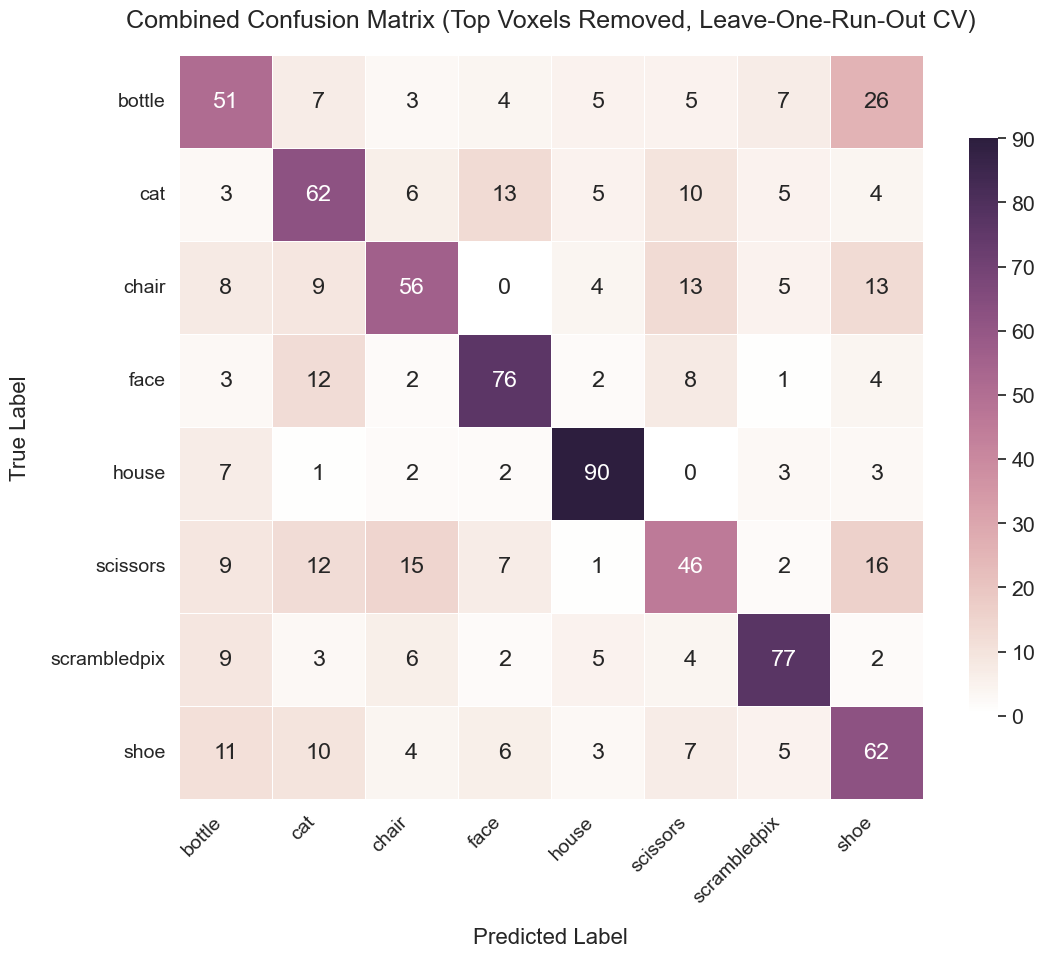

Generating ROC curves and calculating AUC scores...


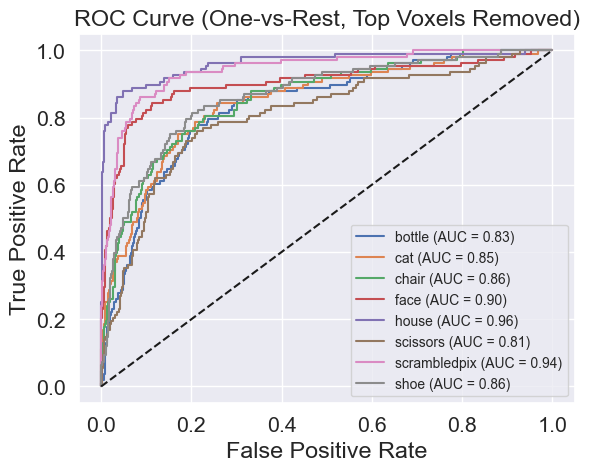

AUC scores for each class:
  bottle: AUC = 0.83
  cat: AUC = 0.85
  chair: AUC = 0.86
  face: AUC = 0.90
  house: AUC = 0.96
  scissors: AUC = 0.81
  scrambledpix: AUC = 0.94
  shoe: AUC = 0.86


In [25]:
# Combine confusion matrices across all folds
combined_conf_matrix_top_removed = sum(conf_matrices_top_removed)

# Plot the combined confusion matrix
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.4)  # Adjust the font scale for better readability

# Define a custom color palette
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

# Create the heatmap
sns.heatmap(
    combined_conf_matrix_top_removed, 
    annot=True, 
    fmt='d', 
    cmap=cmap, 
    xticklabels=grid_search_top_removed.classes_, 
    yticklabels=grid_search_top_removed.classes_,
    linewidths=.5, 
    cbar_kws={"shrink": .75},
    square=True
)

# Add titles and labels with enhanced formatting
plt.title("Combined Confusion Matrix (Top Voxels Removed, Leave-One-Run-Out CV)", fontsize=18, pad=20)
plt.xlabel("Predicted Label", fontsize=16, labelpad=15)
plt.ylabel("True Label", fontsize=16, labelpad=15)

# Rotate x-tick labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=14)
plt.yticks(rotation=0, fontsize=14)

plt.show()

# Convert true labels and predicted probabilities to numpy arrays
y_true_all_top_removed = np.array(y_true_all_top_removed)
y_pred_prob_all_top_removed = np.array(y_pred_prob_all_top_removed)

# Calculate and plot the ROC curve and AUC for each class
print("Generating ROC curves and calculating AUC scores...")
for i, class_name in enumerate(grid_search_top_removed.classes_):
    y_true_binary_top_removed = (y_true_all_top_removed == class_name).astype(int)
    fpr, tpr, _ = roc_curve(y_true_binary_top_removed, y_pred_prob_all_top_removed[:, i])
    auc = roc_auc_score(y_true_binary_top_removed, y_pred_prob_all_top_removed[:, i])
    auc_scores_top_removed.append(auc)
    
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest, Top Voxels Removed)')

# Adjust legend size
plt.legend(loc='lower right', prop={'size': 10})  # Smaller legend size
plt.show()

# Print AUC scores for each class
print("AUC scores for each class:")
for class_name, auc in zip(grid_search_top_removed.classes_, auc_scores_top_removed):
    print(f"  {class_name}: AUC = {auc:.2f}")

In [26]:
# Summary and Comparison of Results

print("### Summary of L2 Logistic Regression Results ###")

# Confusion Matrix Summary
print("\nConfusion Matrix Analysis:")
print("  - The confusion matrix from the standard L2 Logistic Regression analysis indicates how well the model performed across different categories.")
print("  - After removing the top 100 most explanatory voxels, the combined confusion matrix still shows reasonable classification performance.")
print("  - This supports the idea of distributed representations, where even after removing highly explanatory voxels, the brain's activity can still be decoded successfully.")

# AUC Scores Comparison
print("\nAUC Scores Comparison:")
print("  - AUC scores provide a metric for comparing the model's performance in classifying each category.")
print("  - Initial Analysis (with top 200 voxels):")
for class_name, auc in zip(grid_search.classes_, auc_scores):
    print(f"    {class_name}: AUC = {auc:.2f}")

print("\n  - After Removing Top 100 Voxels:")
for class_name, auc in zip(grid_search_top_removed.classes_, auc_scores_top_removed):
    print(f"    {class_name}: AUC = {auc:.2f}")

# Overall Summary
print("\n### Overall Summary ###")
print("  - The L2 Logistic Regression model with feature selection showed strong classification performance across categories.")
print("  - Interestingly, even after removing the top 100 most explanatory voxels, the model was still able to classify the categories with reasonable accuracy.")
print("  - This finding aligns with Haxby et al.'s original work, emphasizing that while certain voxels contribute significantly to classification, information about visual categories is distributed across broader regions of the brain.")
print("  - The results highlight the robustness of distributed representations, where even after removing key features, the underlying brain activity patterns remain informative enough for successful decoding.")

### Summary of L2 Logistic Regression Results ###

Confusion Matrix Analysis:
  - The confusion matrix from the standard L2 Logistic Regression analysis indicates how well the model performed across different categories.
  - After removing the top 100 most explanatory voxels, the combined confusion matrix still shows reasonable classification performance.
  - This supports the idea of distributed representations, where even after removing highly explanatory voxels, the brain's activity can still be decoded successfully.

AUC Scores Comparison:
  - AUC scores provide a metric for comparing the model's performance in classifying each category.
  - Initial Analysis (with top 200 voxels):
    bottle: AUC = 0.82
    cat: AUC = 0.86
    chair: AUC = 0.86
    face: AUC = 0.93
    house: AUC = 0.94
    scissors: AUC = 0.84
    scrambledpix: AUC = 0.93
    shoe: AUC = 0.89

  - After Removing Top 100 Voxels:
    bottle: AUC = 0.83
    cat: AUC = 0.85
    chair: AUC = 0.86
    face: AUC = 0.90
 

In [27]:
#### Now lets get into XGBoost ####

In [ ]:
# Step 1: Set Up the XGBoost Model with Feature Selection
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Encode the labels as integers for XGBoost
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(filtered_conditions)

# Initialize the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Define the hyperparameter grid for tuning
param_grid = {
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
    'xgbclassifier__n_estimators': [50, 100, 200]
}

# Initialize the Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

# Initialize lists to store confusion matrices and AUC scores
conf_matrices_xgb = []
auc_scores_xgb = []

# Arrays to store true labels and predicted probabilities for AUC
y_true_all_xgb = []
y_pred_prob_all_xgb = []

print("Starting Leave-One-Run-Out Cross-Validation with XGBoost and Feature Selection...")

# Perform Leave-One-Run-Out cross-validation
for fold, (train_index, test_index) in enumerate(logo.split(filtered_fmri_vt, y_encoded, groups=filtered_sessions), 1):
    print(f"Processing fold {fold}...")

    # Split the data into training and testing sets
    X_train, X_test = filtered_fmri_vt[train_index], filtered_fmri_vt[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Set up the feature selection + XGBoost pipeline
    pipeline = Pipeline([
        ('feature_selection', SelectKBest(f_classif, k=100)),
        ('xgbclassifier', xgb)
    ])

    # Set up the grid search for hyperparameter tuning
    print("  Tuning hyperparameters...")
    grid_search_xgb = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search_xgb.fit(X_train, y_train)

    # Get the best model
    best_model_xgb = grid_search_xgb.best_estimator_
    print(f"  Best model found with params: {grid_search_xgb.best_params_}")

    # Predict on the test set
    y_pred_xgb = best_model_xgb.predict(X_test)
    y_pred_prob_xgb = best_model_xgb.predict_proba(X_test)

    # Store the true labels and predicted probabilities for AUC calculation
    y_true_all_xgb.extend(y_test)
    y_pred_prob_all_xgb.extend(y_pred_prob_xgb)

    # Compute and store the confusion matrix for this fold
    conf_matrices_xgb.append(confusion_matrix(y_test, y_pred_xgb, labels=grid_search_xgb.classes_))

print("Cross-validation with XGBoost and Feature Selection completed.")


Starting Leave-One-Run-Out Cross-Validation with XGBoost and Feature Selection...
Processing fold 1...
  Tuning hyperparameters...
